In [95]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalMSELoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch

test = True #False, True: batch_size = 3, num_epoch = 2, full dataset
drug_df_path= "../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv"
AUC_df_path = "../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv"
omics_files = {
    'Mut': "../data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt",
    'Exp': "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[1000,100,50],'Exp':[1000,100,50], # Dr.Chiu:exp[500,200,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  'Exp': "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DCSA_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 2
include_omics = ['Exp']
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128
ESPF = True # False True
Drug_SelfAttention = False
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =512
num_attention_heads = 8        
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    
    drug_encode_dims =[1600,400,100] # 50*128  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif model_name = "Omics_DCSA_Model":
    drug_encode_dims =[(max_drug_len+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*128), 700, 70, 1] #
    dense_layer_dim = None
print("drug_encode_dims",drug_encode_dims)
print("dense_layer_dim",dense_layer_dim)
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 500
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 60
Decrease_percent = 0.9
continuous = True
learning_rate=1e-04
# criterion = Custom_LossFunction(loss_type="MSE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()#
criterion =  FocalMSELoss(alpha=8.0, gamma=1.0, regular_type=None, regular_lambda=1e-05)
metrics_type_set = [ "MAE", "R^2"] #"MSE",
metrics_calculator = MetricsCalculator_nntorch(types = metrics_type_set)
""" A customizable loss function class.
    Args:
        loss_type (str): The type of loss to use ("RMSE", "MSE", "MAE", "MAE+MSE", "MAE+RMSE")/("weighted_RMSE", "weighted_MSE", "weighted_MAE", "weighted_MAE+MSE", "weighted_MAE+RMSE").
        loss_lambda (float): The lambda weight for the additional loss (MSE or RMSE) if applicable. Default is MAE+ 1.0*(MSE or RMSE).
        regular_type (str): The type of regularization to use ("L1", "L2", "L1+L2"), or None for no regularization.
        regular_lambda (float): The lambda weight for regularization. Default is 1e-05."""

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_DrugSelfAttention{Drug_SelfAttention}').translate(__translation_table__)




In [ ]:
set_seed(seed)
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)

    if test is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed  
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = MinMaxScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

Exp tensor shape: torch.Size([76, 4692])
Exp num_features 4692


In [ ]:
drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
AUC_df = pd.read_csv( AUC_df_path, sep=',', index_col=0)
# matched AUCfile and omics_data samples

matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))
AUC_df= (AUC_df.T[matched_samples]).T

print("AUC_df",AUC_df.shape)
if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
    
print("drug_df",drug_df.shape)
print("AUC_df",AUC_df.shape)

AUC_df (76, 1440)
drug_df (1440, 9)
AUC_df (76, 1440)


In [99]:
if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
    kfoldCV = 2
    print("kfoldCV",kfoldCV)


if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
    # print("weighted_threshold",weighted_threshold)
    # print("total_samples",total_samples)
    # print("few_samples",few_samples)
    # print("more_samples",more_samples)
    # print("few_weight",few_weight)
    # print("more_weight",more_weight)
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

batch_size 3 num_epoch: 2
drug_df (42, 9)
AUC_df (76, 42)
kfoldCV 2
weighted_threshold: None


In [6]:
import codecs
from subword_nmt.apply_bpe import BPE
import numpy as np

def drug2emb_encoder(smile,vocab_path,sub_csv, max_d=50): # drug_smiles['smiles']
    
    bpe_codes_drug = codecs.open(vocab_path) # token
    # dbpe: initiate BPE function 
    dbpe = BPE(bpe_codes_drug, merges=-1, separator='') # merges=-1 : no limit on the number of merge operations, and BPE will continue merging subword units until it can no longer find any meaningful merges. 
                                                        #In other words, it will keep merging until the training process converges.
                                                        #separator='' : uses an empty string ('') as a separator between subword units.
    idx2word_d = sub_csv['index'].values # index : substructure EX:CC
    words2idx_d = dict(zip(idx2word_d, range(0, len(idx2word_d))))# zip substructure with it's substructure character length. EX:(CC,2)

    tokens = dbpe.process_line(smile).split() # BPE tokenizes the input SMILES # tokens=vocabulary set # ex:[ 'Nc1nc(', 'O)', 'c2nc(', 'Br)', 'n(', '[C@@H]3' ]
        # tokens: list of subwords of a word
    try:
        i1 = np.asarray([words2idx_d[subword ] for subword  in tokens]) # i1: subword在sub_csv file中的index ; i: tokens中的subword
    except:# 如果tokens是空值，或tokens中有subword沒有在words2idx_d字典裡
        i1 = np.array([0])
    l = len(i1)
    if l < max_d: # subword list 長度小於50
        i = np.pad(i1, (0, max_d - l), 'constant', constant_values=0) # 補零補到50，前面是subword在sub_csv file中的index
        input_mask = ([1] * l) + ([0] * (max_d - l)) # i的mask
    else: # subword list 長度大於等於50
        i = i1[:max_d] # 取前50個subwords(index) # !!!!須改方法!!!!
        input_mask = [1] * max_d # i的mask
    return i, np.asarray(input_mask),tokens

In [ ]:
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)#drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

# Convert your data to tensors if they're in numpy
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32).to(device)
print(response_matrix_tensor.shape)
print(drug_encode.values[0][2])

num_ccl,num_drug:  76 42
torch.Size([76, 42])
['Nc1nc(', 'O)', 'c2nc(', 'Br)', 'n(', '[C@@H]3', 'O[C@@H]4', 'CO', 'P', '(O)', '(=O)', 'O[C@H]4', '[C@H]3', 'O)c2', 'n1']


In [32]:
t=([1,2,3,4],123,[4,5,6])
t[0]

[1, 2, 3, 4]

In [58]:
for d in drug_encode.values:
    print(d[:2])

(array([ 696,   61,  603,  472,  567,  302, 2058,   92,    2,   96,   63,
       2363,  269,  744,  168,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]))
(array([896, 452, 152, 400, 940, 169, 172, 337, 163, 374, 308, 424,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]))
(array([ 196, 1263,  402,  915, 221

In [20]:
id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
# repeat the test id
if splitType == "byCCL":
    repeatNum = num_drug
elif splitType == "byDrug":
    repeatNum = num_ccl
id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')


id_unrepeat_train (60,)
id_unrepeat_val (8,)
id_unrepeat_test (8,)
id_unrepeat_train_val (68,)
id_test.shape (336,)


In [21]:
print(id_test[:10])

[630 631 632 633 634 635 636 637 638 639]


In [60]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

test_dataset = Subset(dataset, id_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # , num_workers=4, pin_memory=True
#create whole dataset
whole_loader = DataLoader(dataset, batch_size=2000, shuffle=False) # 685440


drug_features_tensor tensor([[[ 696,   61,  603,  ...,    0,    0,    0],
         [   1,    1,    1,  ...,    0,    0,    0]],

        [[ 896,  452,  152,  ...,    0,    0,    0],
         [   1,    1,    1,  ...,    0,    0,    0]],

        [[ 196, 1263,  402,  ...,    0,    0,    0],
         [   1,    1,    1,  ...,    0,    0,    0]],

        ...,

        [[ 145,  163, 1156,  ...,    0,    0,    0],
         [   1,    1,    1,  ...,    0,    0,    0]],

        [[2379,  102,   89,  ...,    0,    0,    0],
         [   1,    1,    1,  ...,    0,    0,    0]],

        [[  19,  625,  407,  ...,    0,    0,    0],
         [   1,    1,    1,  ...,    0,    0,    0]]], device='cuda:0')
self.num_drugs 42


NameError: name 'id_test' is not defined

In [23]:
%%time
# Evaluation

if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
model.to(device=device)
# best_weight_path = './inference/BestFold2_test_loss0.0044098_BestValEpo8_ModelOmics_DrugESPF_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/'
# best_weight = best_weight_path + "BestValWeight.pt"

# model.load_state_dict(torch.load(best_weight))

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 _ ,_,
 eval_outputs_before_final_activation_list, 
 mean_batch_eval_lossWOpenalty)  = evaluation(model, None,None,
                                             criterion, whole_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')



State_dict for Sequential(
  (0): Linear(in_features=4692, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
  (5): ReLU()
) loaded successfully.

 Drug_SelfAttention is not applied 

DrugCell
CPU times: user 260 ms, sys: 58 ms, total: 318 ms
Wall time: 1.29 s


In [11]:
predAUCwithUnknownGT_list = np.concatenate(predAUCwithUnknownGT)
print(predAUCwithUnknownGT_list.shape)
predAUCmatrix = predAUCwithUnknownGT_list.reshape(476, 1440) # numpy.ndarray

predAUCmatrix_df = pd.DataFrame(predAUCmatrix, columns=AUC_df.columns, index=AUC_df.index)
# Output to CSV
predAUCmatrix_df.to_csv(best_weight_path+'predicted AUC values with UnknownGroundTruth samples.csv')
print("CSV file has been saved.")

(685440,)
CSV file has been saved.


In [20]:
print("eval_targets\n",eval_targets[0][:10])
print("eval_outputs_before_final_activation_list\n",eval_outputs_before_final_activation_list[0][:10])
print("eval_outputs\n",eval_outputs[0][:10])

eval_targets
 tensor([0.9036, 0.9385, 0.5121, 0.8205, 0.8813, 0.7088, 0.7894, 0.7654, 0.8884,
        0.7771], device='cuda:0')
eval_outputs_before_final_activation_list
 [1.7557875  1.7566662  0.06698469 1.2181281  2.2245376  1.3837595
 1.3948462  1.3587809  2.2915099  1.4390914 ]
eval_outputs
 tensor([0.8527, 0.8528, 0.5167, 0.7717, 0.9024, 0.7996, 0.8014, 0.7956, 0.9082,
        0.8083], device='cuda:0')


In [18]:
mean_batch_eval_lossWOpenalty

array(0.0037629, dtype=float32)

In [17]:
metrics_calculator = MetricsCalculator_nntorch()
eval_metrics= metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs))
print(eval_metrics)

{'MSE': tensor(0.0058, device='cuda:0'), 'MAE': tensor(0.0555, device='cuda:0'), 'R^2': tensor(0.7736, device='cuda:0')}


In [33]:
if splitType == "byCCL":
    id_unrepeat_whole = list(range(476))
elif splitType == "byDrug":
    id_unrepeat_whole = list(range(1440))
    id_unrepeat_whole[:10], id_unrepeat_whole[-10:]  # Display the first and last 10 elements to confirm

eval_pearson, eval_spearman,eval_AllSameValuesList_count  = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_whole,torch.cat(eval_targets),torch.cat(eval_outputs))

Text(0.5, 0.98, 'Density Plot of Correlation Omics_DrugESPF_Model')

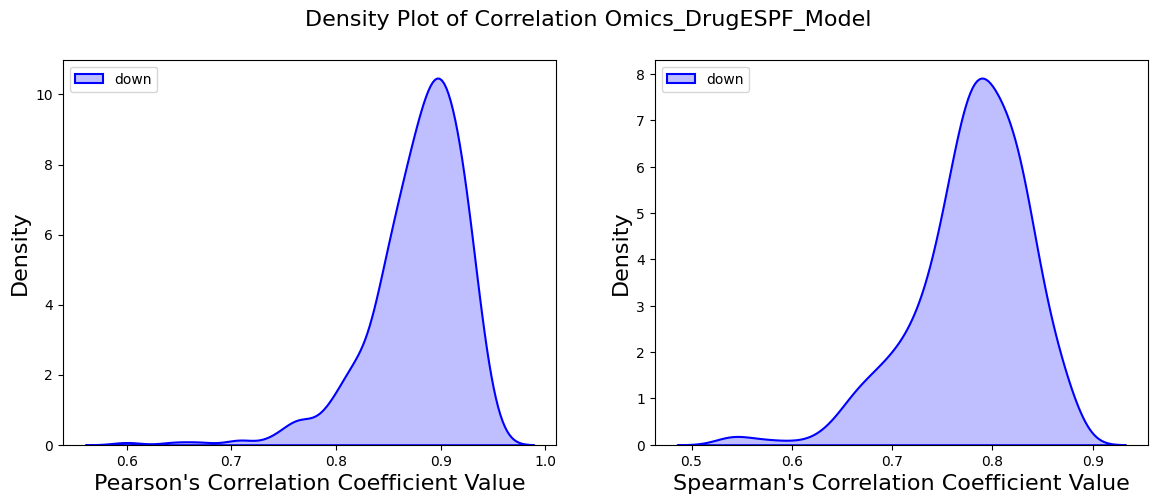

In [34]:
#pearson
# Create a density plot using seaborn's kdeplot function
fig=plt.figure(figsize=(14, 5))
# Set the title of the plot

plt.subplot(1,2,1)
# sns.kdeplot(test_pearson1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_pearson, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Pearson\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 

plt.subplot(1,2,2)
#spearman
# Create a density plot using seaborn's kdeplot function
# sns.kdeplot(test_spearman1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_spearman, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Spearman\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 
fig.suptitle(f'Density Plot of Correlation {model_name}', fontsize=16)

In [35]:
# for name, pearson in [("Test", test_pearson1)]:
#     print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
# for name, spearman in [("Test", test_spearman1)]:
#     print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")

for name, pearson in [("Test", eval_pearson)]:
    print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
for name, spearman in [("Test", eval_spearman)]:
    print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")


Mean Median Mode Test Pearson Omics_DrugESPF_Model:	0.877792 ± 0.0454	-1.693300	 0.886623	ModeResult(mode=0.9, count=64)

Mean Median Mode Test Spearman Omics_DrugESPF_Model:	0.778543 ± 0.0564	-1.056978	 0.785663	ModeResult(mode=0.77, count=43)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

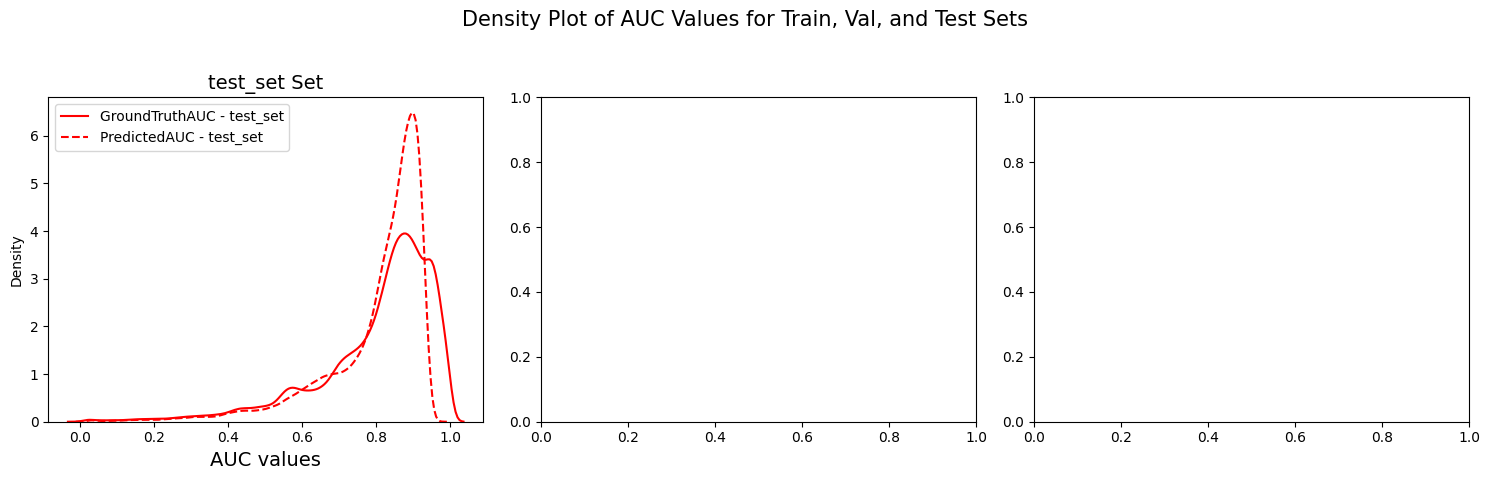

In [36]:
datas = [(eval_targets, eval_outputs, 'test_set', 'red')]
# plot Density_Plot_of_AUC_Values of train val test datasets
hyperparameter_folder_path = None
Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)

In [37]:
predAUCmatrix_df = pd.read_csv("./inference/BestFold2_test_loss0.0044098_BestValEpo8_ModelOmics_DrugESPF_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

In [11]:
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list.txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
CCLtypeDF= (CCLtypeDF.T[matched_samples]).T
print(CCLtypeDF.shape)
type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeLineage"] == "Bowel"].tolist()
print(type_indices)
# print(predAUCmatrix_df.loc[type_indices])

(480, 1)
(476, 1)
['ACH-000007', 'ACH-000252', 'ACH-000296', 'ACH-000403', 'ACH-000421', 'ACH-000467', 'ACH-000532', 'ACH-000552', 'ACH-000565', 'ACH-000651', 'ACH-000680', 'ACH-000842', 'ACH-000895', 'ACH-000926', 'ACH-000943', 'ACH-000950', 'ACH-000955', 'ACH-000957', 'ACH-000958', 'ACH-000959', 'ACH-000967', 'ACH-000970', 'ACH-000971', 'ACH-000982', 'ACH-000985', 'ACH-000991', 'ACH-000997']


In [14]:
# get GT AUC of specific drug and type of ccl
GT_AUC_df_Bowel_5flu = (AUC_df.loc[type_indices])[['FLUOROURACIL (BRD:BRD-K24844714-001-24-5)']]
print(np.concatenate(GT_AUC_df_Bowel_5flu.values).shape)

# get predicted AUC of sepecific drug and type of ccl
predAUCmatrix_df_Bowel_5flu = (predAUCmatrix_df.loc[type_indices])[['FLUOROURACIL (BRD:BRD-K24844714-001-24-5)']]
print(np.concatenate(predAUCmatrix_df_Bowel_5flu.values).shape)

(27,)
(27,)


In [ ]:
# get specific mut gene label 0/1
include_omics = ['Mut']
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)
    omics_data_dict[omic_type] = omics_data_dict[omic_type].loc[type_indices] #  index of specific CCL type's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]).shape ) 
    if omic_type == "Mut":
        sample_mut_label = ((omics_data_dict[omic_type])['TP53'] == 1).astype(int).tolist()
        print(sample_mut_label)
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = MinMaxScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    

(27, 6009)
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]


In [24]:
#get mask from GT_AUC_df_Bowel_5flu and get GT_AUC_df_Bowel_5flu_dropnan
mask = ~np.isnan(np.concatenate(GT_AUC_df_Bowel_5flu.values))
GT_AUC_df_Bowel_5flu_dropnan = GT_AUC_df_Bowel_5flu.dropna()
GT_AUC_df_Bowel_5flu_dropnan.shape

(15, 1)

In [25]:
# get mutation label after mask for GT boxplot
GT_mut_label_masked=np.array(sample_mut_label)[mask]
print("GT_mut_label_masked",GT_mut_label_masked)
# turn 0/1 to 'w/0 TP53_Mut'/'TP53_Mut'
GT_mut_label_masked = ['TP53_Mut' if label == 1 else 'w/0 TP53_Mut' for label in GT_mut_label_masked]
print(len(GT_mut_label_masked))
sample_mut_label = ['TP53_Mut' if label == 1 else 'w/0 TP53_Mut' for label in sample_mut_label]
print("sample_mut_label/n",sample_mut_label)

GT_mut_label_masked [0 1 1 1 1 1 0 0 0 1 1 0 0 1 1]
15
sample_mut_label/n ['w/0 TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/0 TP53_Mut', 'w/0 TP53_Mut', 'TP53_Mut', 'w/0 TP53_Mut', 'w/0 TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/0 TP53_Mut', 'w/0 TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut']


7
20


/tmp/ipykernel_3040/2524763574.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="mutation_status", y="predicted AUC", data=df, palette=custom_palette)
/tmp/ipykernel_3040/2524763574.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="mutation_status", y="GroundTruth AUC", data=GTdf, palette=custom_palette)


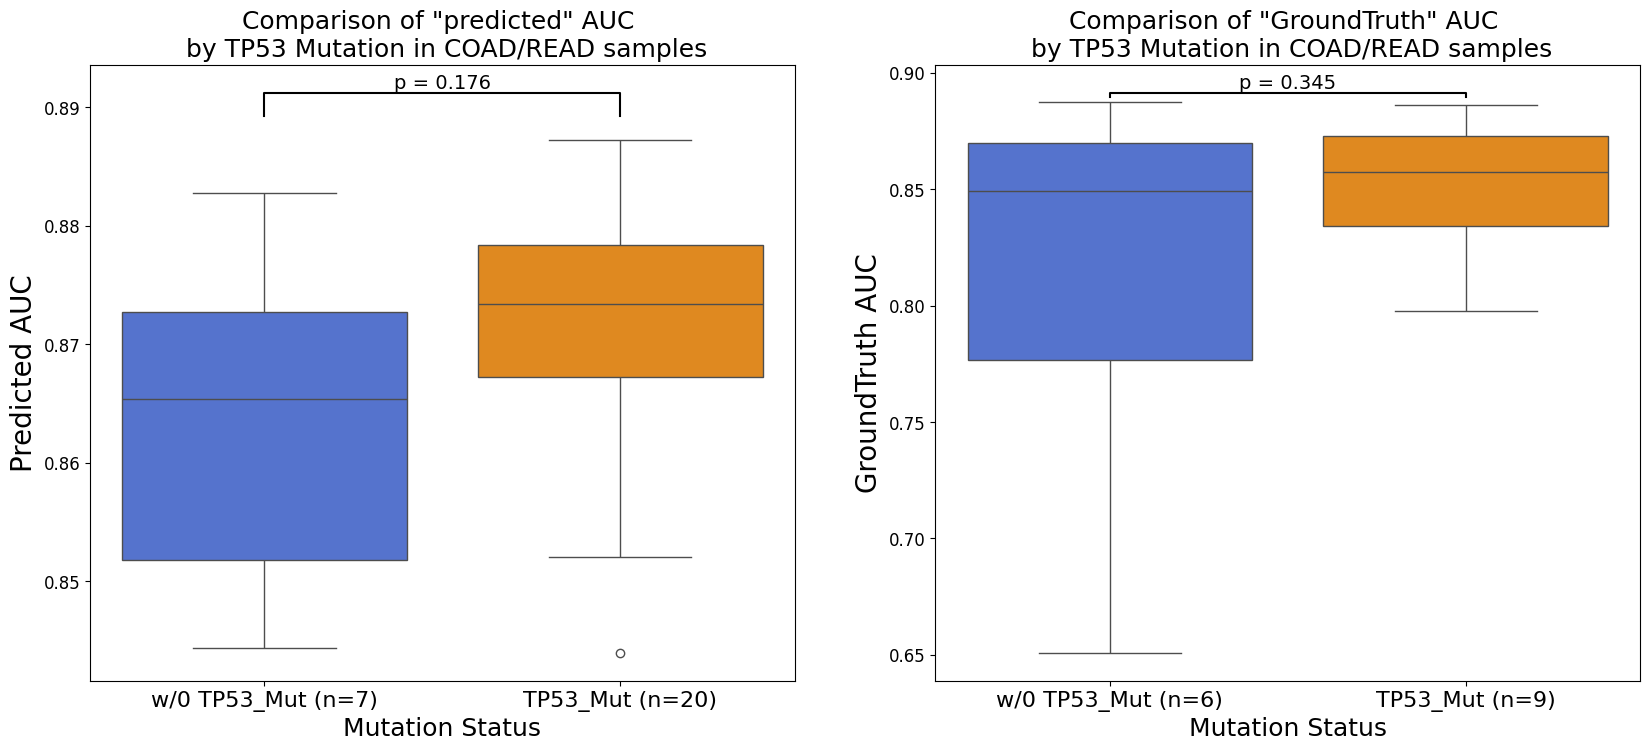

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame({'predicted AUC': np.concatenate(predAUCmatrix_df_Bowel_5flu.values) , 'mutation_status': sample_mut_label})
# Perform t-test
group1 = df[df["mutation_status"] == "w/0 TP53_Mut"]["predicted AUC"]
group2 = df[df["mutation_status"] == "TP53_Mut"]["predicted AUC"]
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
custom_palette = {"w/0 TP53_Mut": "royalblue", "TP53_Mut": "darkorange"}
fig=plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
ax = sns.boxplot(x="mutation_status", y="predicted AUC", data=df, palette=custom_palette)
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = df["predicted AUC"].max() + 0.002, 0.002  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.xticks([0, 1], [f'w/0 TP53_Mut (n={len(group1)})', f'TP53_Mut (n={len(group2)})'], fontsize=16)
plt.title('Comparison of "predicted" AUC \n by TP53 Mutation in COAD/READ samples',fontsize=18)
plt.xlabel('Mutation Status', fontsize=18)
plt.ylabel('Predicted AUC', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)
plt.subplot(1,2,2)
GTdf = pd.DataFrame({'GroundTruth AUC': np.concatenate(GT_AUC_df_Bowel_5flu_dropnan.values) , 'mutation_status': GT_mut_label_masked})
group1 = GTdf[GTdf["mutation_status"] == "w/0 TP53_Mut"]["GroundTruth AUC"]
group2 = GTdf[GTdf["mutation_status"] == "TP53_Mut"]["GroundTruth AUC"]
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
custom_palette = {"w/0 TP53_Mut": "royalblue", "TP53_Mut": "darkorange"}
ax = sns.boxplot(x="mutation_status", y="GroundTruth AUC", data=GTdf, palette=custom_palette)
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = GTdf["GroundTruth AUC"].max() + 0.002, 0.002  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.xticks([0, 1], [f'w/0 TP53_Mut (n={len(group1)})', f'TP53_Mut (n={len(group2)})'], fontsize=16)
plt.xlabel('Mutation Status', fontsize=18)
plt.ylabel('GroundTruth AUC', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)
plt.title('Comparison of "GroundTruth" AUC \n by TP53 Mutation in COAD/READ samples',fontsize=18)
plt.show()

## Attention Score Matrix

In [61]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalMSELoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch, MetricsCalculator_numpy

test = False #False, True: batch_size = 3, num_epoch = 2, full dataset

omics_files = {
    'Mut': "../data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt",
    'Exp': "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[1000,100,50],'Exp':[1000,100,50], # Dr.Chiu:exp[500,200,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  'Exp': "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DCSA_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 5
include_omics = ['Exp']
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128
ESPF = True # False True
Drug_SelfAttention = True
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =512
num_attention_heads = 8        
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    
    drug_encode_dims =[1600,400,100] # 50*128  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 200
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 60
Decrease_percent = 0.9
continuous = True
learning_rate=1e-04
metrics_type_set=["MSE", "MAE", "R^2"]
metrics_calculator = MetricsCalculator_nntorch(types = metrics_type_set)
#criterion = Custom_LossFunction(loss_type="MSE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()#
criterion =  FocalMSELoss(alpha=8.0, gamma=1.0, regular_type=None, regular_lambda=1e-05)
""" A customizable loss function class.
    Args:
        loss_type (str): The type of loss to use ("RMSE", "MSE", "MAE", "MAE+MSE", "MAE+RMSE")/("weighted_RMSE", "weighted_MSE", "weighted_MAE", "weighted_MAE+MSE", "weighted_MAE+RMSE").
        loss_lambda (float): The lambda weight for the additional loss (MSE or RMSE) if applicable. Default is MAE+ 1.0*(MSE or RMSE).
        regular_type (str): The type of regularization to use ("L1", "L2", "L1+L2"), or None for no regularization.
        regular_lambda (float): The lambda weight for regularization. Default is 1e-05."""

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_DrugSelfAttention{Drug_SelfAttention}').translate(__translation_table__)



Training on device cuda.


In [62]:
predAUCmatrix_df = pd.read_csv("./inference/BestFold2_test_loss0.0044098_BestValEpo8_ModelOmics_DrugESPF_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

In [82]:
drug_ID = "BRD-K24844714-001-24-5"
cell_ID = "ACH-000007"

In [ ]:
include_omics = ['Exp']
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)
    print((omics_data_dict[omic_type]).shape )
    if omic_type == "Mut":
        sample_mut_label = ((omics_data_dict[omic_type])['TP53'] == 1).astype(int).tolist()
        print(sample_mut_label)
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = MinMaxScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    
    omics_data_dict[omic_type] = (omics_data_dict[omic_type].loc[cell_ID])#.reshape(1, -1)#  index of specific CCL's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]) )

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]#[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

    

(476, 4692)
A1BG       0.019957
A2M        0.018265
A2ML1      0.000000
A4GALT     0.002135
AADAT      0.478295
             ...   
ZNF91      0.715013
ZNF93      0.056755
ZP3        0.509008
ZSCAN18    0.004398
ZWINT      0.608185
Name: ACH-000007, Length: 4692, dtype: float64
Exp tensor shape: torch.Size([1, 4692])
Exp num_features 4692


/tmp/ipykernel_47041/3816806599.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)


In [64]:
drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# matched AUCfile and omics_data samples

# matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))
# AUC_df= (AUC_df.T[matched_samples]).T

print("AUC_df",AUC_df.shape)
if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
    
print("drug_df",drug_df.shape)
print("AUC_df",AUC_df.shape)

AUC_df (480, 1440)
drug_df (1440, 9)
AUC_df (480, 1440)


In [ ]:
# get specific drug and ccl
drug_df= drug_df[drug_df['BRD_ID'] == drug_ID]
print(drug_df)
print("\n")
#get pair GT response 
matching_columns_name = [col for col in AUC_df.loc[cell_ID].index if drug_ID in col]
print("matching_columns_name", matching_columns_name)

GT_AUC_df_pair = (AUC_df.loc[cell_ID])[matching_columns_name] # MK-5108 (BRD:BRD-K53665955-001-03-0)
print("GT_AUC_df_pair\n",GT_AUC_df_pair)
#get pair predicted response 
predAUCmatrix_df_pair = (predAUCmatrix_df.loc[cell_ID])[matching_columns_name]
print("predAUCmatrix_df_pair\n",predAUCmatrix_df_pair)

                              BRD_ID            name  \
Name                                                   
FLUOROURACIL  BRD-K24844714-001-24-5  5-fluorouracil   

                                         moa      target disease.area  \
Name                                                                    
FLUOROURACIL  thymidylate synthase inhibitor  DPYD, TYMS     oncology   

                                                     indication     phase  \
Name                                                                        
FLUOROURACIL  colorectal cancer, breast cancer, pancreatic c...  Launched   

                             smiles  \
Name                                  
FLUOROURACIL  Fc1c[nH]c(=O)[nH]c1=O   

                                                   MACCS166bits  
Name                                                             
FLUOROURACIL  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  


matching_columns_name ['FLUOROURACIL (BRD:BRD-K24844714-001-2

In [66]:
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]

    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))

    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

response_matrix_tensor = torch.tensor(GT_AUC_df_pair.values, dtype=torch.float32).to(device).unsqueeze(1)
print(omics_data_tensor_dict)
print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
print(response_matrix_tensor.shape)
print(drug_encode.values[0][2])

num_ccl,num_drug:  1 1
{'Exp': tensor([[0.0200, 0.0183, 0.0000,  ..., 0.5090, 0.0044, 0.6082]],
       device='cuda:0')}
torch.Size([1, 2, 50])
torch.Size([1, 1])
['F', 'c1c[nH]', 'c', '(=O)', '[nH]', 'c1', '=O']


In [67]:
if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [68]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
one_loader = DataLoader(dataset, batch_size=1, shuffle=False)

drug_features_tensor tensor([[[ 49, 616,  26,  63, 118,  70, 180,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0],
         [  1,   1,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0]]], device='cuda:0')
self.num_drugs 1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import math
import copy
import numpy as np
torch.manual_seed(42)
np.random.seed(42)
class SinusoidalPositionalEncoding(nn.Module):
  def __init__(self, hidden_size, max_len=50):
    super(SinusoidalPositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, hidden_size) # torch.Size([50, 128])
    position = torch.arange(0, max_len).float().unsqueeze(1) # torch.Size([50, 1]) # 0~50
    div_term = torch.exp(torch.arange(0, hidden_size, 2).float() *
                         (-torch.log(torch.Tensor([10000])) / hidden_size)) # [max_len / 2]
                        #生成一個數位 [0， 2， 4， ...， hidden_size-2] 的張量（偶數索引）。
    pe[:, 0::2] = torch.sin(position * div_term) #將 sine 函數應用於位置編碼張量 （pe） 的偶數維數。
    pe[:, 1::2] = torch.cos(position * div_term) #將餘弦函數應用於位置編碼張量 （pe） 的奇數維數。
    pe = pe.unsqueeze(0) # torch.Size([1, 50, 128])
    # register pe to buffer and require no grads#緩衝區的參數在訓練期間不會更新
    self.register_buffer('pe', pe)
  def forward(self, x):
    # x: [batch, seq_len, hidden_size]
    # we can add positional encoding to x directly, and ignore other dimension
    return x + self.pe[:,:x.size(1)].to(x.device)# x.size(1)= 50
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len):#(128, 50)
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, hidden_size)#(128, 50) # 50個pos id(0~50)用128維vector來表示位置資訊

    def forward(self, x):# x: torch.Size([bsz, 50]) # 50個子結構id
            # seq_length = seq.size(1) #seq:(batchsize=64,50)# seq_length:50 # 50個onehot categorical id 𝜖(0~2585)
            # position_ids = torch.arange(seq_length, dtype=torch.long, device=seq.device) #position_ids:torch.Size([50]) (0~50)
            # position_ids = position_ids.unsqueeze(0).expand_as(seq)#position_ids:torch.Size([bsz, 50])
        seq_length = x.size(1) #x:(batchsize=64,50)# 50個onehot categorical id 𝜖(0~2585)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=x.device) #position_ids:torch.Size([50]) (0~50)
        position_ids = position_ids.unsqueeze(0).expand_as(x) #position_ids =>torch.Size([bsz, 50])
        return self.position_embeddings(position_ids)# generate torch.Size([bsz, 50, 128])位置特徵，每一個位置都用128為來描述
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon
    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta
class Embeddings(nn.Module): # word embedding + positional encoding
    """Construct the embeddings from protein/target, position embeddings."""
    def __init__(self, hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type ,substructure_size):
        super(Embeddings, self).__init__()
        self.word_embeddings = nn.Embedding(substructure_size, hidden_size)#(2586,128)# 50個onehot categorical id(0~2585)用128維來表示類別資訊
        self.pos_emb_type = pos_emb_type
        if pos_emb_type == "learned":#Learned Positional Embedding
            self.position_embeddings = LearnedPositionalEncoding(hidden_size, max_len=max_drug_len)#(128,50)
                #self.position_embeddings = nn.Embedding(max_drug_len, hidden_size)#(50, 128)# 50個pos id(0~50)用128維vector來表示位置資訊
        elif pos_emb_type == "sinusoidal":#Sinusoidal Position Encoding
            self.position_embeddings = SinusoidalPositionalEncoding(hidden_size, max_len=max_drug_len)#(128,50)
        self.LayerNorm = nn.LayerNorm(hidden_size)#128
        self.dropout = nn.Dropout(hidden_dropout_prob)#0.1
    def forward(self, seq):# torch.Size([bsz, 50]) # 50個子結構id 
        words_embeddings = self.word_embeddings(seq) #seq:(batchsize=64,50)# generate(bze,50,128)類別特徵
        # words_embeddings: torch.Size([bsz, 50, 128])50個sub,其對應的representation
    #Learned Positional Embedding
        if self.pos_emb_type == "learned":
            position_embeddings = self.position_embeddings(seq)# generate torch.Size([bsz, 50, 128])位置特徵
            #position_embeddings: torch.Size([bsz, 50, 128])
            embeddings = words_embeddings + position_embeddings # embeddings:torch.Size([bsz, 50, 128])
    #Sinusoidal Position Encoding
        elif self.pos_emb_type == "sinusoidal":
            embeddings = self.position_embeddings(words_embeddings)  # Shape: [bsz, 50, 128] 
         
        embeddings = self.LayerNorm(embeddings)#LayerNorm embeddings torch.Size([bsz, 50, 128])
        embeddings = self.dropout(embeddings)#dropout embeddings torch.Size([bsz, 50, 128])
        return embeddings # emb.shape:torch.Size([bsz, 50, 128])
    
class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob):
        super(SelfAttention, self).__init__()# (128,8,0.1)
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))
        self.num_attention_heads = num_attention_heads #8 頭數
        self.attention_head_size = int(hidden_size / num_attention_heads)#128/8=16 頭的維度
        self.all_head_size = self.num_attention_heads * self.attention_head_size#8*16=128 頭的維度總和等於feature數

        self.query = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.key = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.value = nn.Linear(hidden_size, self.all_head_size)#(128,128)

        self.dropout = nn.Dropout(attention_probs_dropout_prob)#0.1

    def transpose_for_scores(self, x): # x: torch.Size([bsz, 50, 128]) # diveide the whole 128 features into 8 heads, result 16 features per head
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) # (8,16)
        # x.size()[:-1] torch.Size([bsz, 50]) # new_x_shape: torch.Size([bsz, 50, 8, 16])
        x = x.view(*new_x_shape) # changes the shape of x to the new_x_shape # x torch.Size([bsz, 50, 8, 16])
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, mask): 
        # hidden_states:emb.shape:torch.Size([bsz, 50, 128]); attention_mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
        mixed_query_layer = self.query(hidden_states) #hidden_states: torch.Size([bsz, 50, 128])
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states) # mixed_value_layer: torch.Size([bsz, 50, 128])

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer) #value_layer:torch.Size([bsz, 8, 50, 16])
        
        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))# key_layer.transpose(-1, -2):torch.Size([bsz, 8, 16, 50])
        # attention_scores:torch.Size([bsz, 8, 50, 50])
        # Scaled Dot-Product: Prevent the dot products from growing too large, causing gradient Vanishing.
        attention_scores = attention_scores / math.sqrt(self.attention_head_size) # /16
        
        attention_mask = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))#(bsz,len)->(bsz,len,1),(bsz,1,len)#after batch-wise outer product(bsz,len,len) #bmm only take float
        attention_mask = attention_mask.unsqueeze(1).expand_as(attention_scores) # not neccessory because broadcasting
        attention_scores = attention_scores.masked_fill(attention_mask == 0, -1e8) #torch.Size([bsz, head, 50, 50])[i,i,i,i,....,-1e8,-1e8,-1e8,....] # Replaces values where mask == 0 with -1e8 # -1e8 softmax need very small number so it will output 0
       
        # Normalize the attention scores to probabilities.
        attention_probs_0 = F.softmax(attention_scores, dim=-1) # attention_probs_0:torch.Size([bsz, 8, 50, 50])
        attention_probs_0 = attention_probs_0.masked_fill(attention_mask == 0, 0)#Replaces values where mask == 0 with 0.0: to prevent the empty element to have value due to softmax 
        # This is actually dropping out entire tokens to attend to, which might seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs_drop = self.dropout(attention_probs_0)

        context_layer = torch.matmul(attention_probs_drop, value_layer) #context_layer:torch.Size([bsz, 8, 50, 16])
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() #context_layer:torch.Size([bsz, 50, 8, 16])
        # context_layer.size()[:-2] torch.Size([bsz, 50])
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) #new_context_layer_shape:torch.Size([bsz, 50, 128]) #(128,)
        context_layer = context_layer.view(*new_context_layer_shape) #context_layer:torch.Size([bsz, 50, 128])
        return context_layer, attention_probs_0
    
class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after self-attention
    def __init__(self, hidden_size, dropout_prob):
        super(SelfOutput, self).__init__()# (128,0.1)
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states    

class Attention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Attention, self).__init__()
        self.selfAttention = SelfAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob)
        self.output = SelfOutput(hidden_size, hidden_dropout_prob)# apply linear and skip conneaction and LayerNorm and dropout after self-attention

    def forward(self, input_tensor, attention_mask):
        # input_tensor:emb.shape:torch.Size([64, 50, 128]); attention_mask: ex_e_mask:torch.Size([64, 1, 1, 50])
        self_output, attention_probs_0 = self.selfAttention(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output, attention_probs_0    


class Intermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super(Intermediate, self).__init__()# (128,512)
        self.dense = nn.Linear(hidden_size, intermediate_size)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = F.relu(hidden_states)
        return hidden_states

class Output(nn.Module):# do linear, skip connection, LayerNorm, dropout after intermediate(Feed Forward block)
    def __init__(self, intermediate_size, hidden_size, hidden_dropout_prob):
        super(Output, self).__init__()# (512,128,0.1)
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states # transformer 最後的輸出


class Encoder(nn.Module):  # Transformer Encoder for drug feature # Drug_SelfAttention
    def __init__(self, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):#(128/136,512,8,0.1,0.1)
        super(Encoder, self).__init__() # (128,512,8,0.1,0.1)
        self.attention = Attention(hidden_size, num_attention_heads,
                                   attention_probs_dropout_prob, hidden_dropout_prob)# (128,8,0.1,0.1)
        self.intermediate = Intermediate(hidden_size, intermediate_size)# (128,512)
        self.output = Output(intermediate_size, hidden_size, hidden_dropout_prob)# (512,128,0.1)

    def forward(self, hidden_states, attention_mask):
        # hidden_states:emb.shape:torch.Size([64, 50, 128/136]); attention_mask: ex_e_mask:torch.Size([64, 1, 1, 50/50+c])
        attention_output,attention_probs_0 = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output , attention_probs_0    # transformer 最後的輸出

class Encoder_MultipleLayers(nn.Module): # 用Encoder更新representation n_layer次 # DeepTTA paper寫6次
    def __init__(self, n_layer, hidden_size, intermediate_size,
                 num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob): #(8,128,512,8,0.1,0.1)
        super(Encoder_MultipleLayers, self).__init__()
        layer = Encoder(hidden_size, intermediate_size, num_attention_heads,
                        attention_probs_dropout_prob, hidden_dropout_prob) # (128,512,8,0.1,0.1)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layer)])

    def forward(self, hidden_states, attention_mask, output_all_layers=False):
        embeddings_all_layers = []
        attention_probs_all_layers = []
        for layer_module in self.layer:
            hidden_states, attention_probs_0 = layer_module(hidden_states, attention_mask) 
            if output_all_layers is True:
               embeddings_all_layers.append(hidden_states)
               attention_probs_all_layers.append(attention_probs_0)
               return embeddings_all_layers,attention_probs_all_layers
        return hidden_states, attention_probs_0  # transformer 最後的輸出

        
class CrossAttention(nn.Module): # substructures 和 pathways 的 cross-attention
    def __init__(self, drug_dim, cell_dim, attn_dim):
        super(CrossAttention, self).__init__()
        self.query_proj = nn.Linear(drug_dim, attn_dim)  # Project drug features to query space
        self.key_proj = nn.Linear(cell_dim, attn_dim)    # Project cell features to key space
        self.value_proj = nn.Linear(cell_dim, attn_dim)  # Project cell features to value space
        self.scale = attn_dim ** -0.5  # Scaling factor for dot product attention

    def forward(self, drug_subunits, cell_subunits, drug_sub_mask, cell_sub_mask):
        # drug_subunits: (batch_size, num_drug_subunits, drug_dim)
        # cell_subunits: (batch_size, num_cell_subunits, cell_dim)

        # Project drug features to query, and cell features to key and value
        queries = self.query_proj(drug_subunits)        # Shape: (batch_size, num_drug_subunits, attn_dim)
        keys = self.key_proj(cell_subunits)             # Shape: (batch_size, num_cell_subunits, attn_dim)
        values = self.value_proj(cell_subunits)         # Shape: (batch_size, num_cell_subunits, attn_dim)

        # Compute attention scores (scaled dot product)
        attn_scores = torch.matmul(queries, keys.transpose(-2, -1)) * self.scale  # Shape: (batch_size, num_drug_subunits, num_cell_subunits)
        attn_weights = F.softmax(attn_scores, dim=-1)     # Normalize scores to get attention weights

        # Compute the final attended output
        attended_values = torch.matmul(attn_weights, values)  # Shape: (batch_size, num_drug_subunits, attn_dim)
        
        return attn_weights, attended_values
'''
# Example usage
batch_size = 2
num_drug_subunits, drug_dim = 5, 128
num_cell_subunits, cell_dim = 7, 256
attn_dim = 16

drug_subunits = torch.randn(batch_size, num_drug_subunits, drug_dim)
cell_subunits = torch.randn(batch_size, num_cell_subunits, cell_dim)

cross_attn = CrossAttention(drug_dim=drug_dim, cell_dim=cell_dim, attn_dim=attn_dim)
attn_weights, attended_values = cross_attn(drug_subunits, cell_subunits)

print("Attention Weights Shape:", attn_weights.shape)  # (batch_size, num_drug_subunits, num_cell_subunits)
print("Attended Values Shape:", attended_values.shape)  # (batch_size, num_drug_subunits, attn_dim)
'''



# End of Modules------------------------------------------------------------------------------------------------------------------------------------------------------




# Models------------------------------------------------------------------------------------------------------------------------------------------------------
class Omics_DrugESPF_Model(nn.Module):
    def __init__(self,omics_encode_dim_dict,drug_encode_dims, activation_func,activation_func_final,dense_layer_dim, device, ESPF, Drug_SelfAttention,
                 pos_emb_type, hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeaetures_dict, max_drug_len, TCGA_pretrain_weight_path_dict=None):
        super(Omics_DrugESPF_Model, self).__init__()

        def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
            state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
            encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
            model.load_state_dict(encoder_state_dict)  # Load only the encoder part
            model_keys = set(model.state_dict().keys())  # Check if the keys match
            loaded_keys = set(encoder_state_dict.keys())
            if model_keys == loaded_keys:
                print(f"State_dict for {model} loaded successfully.")
            else:
                print(f"State_dict does not match the model's architecture for {model}.")
                print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)

# Create subnetworks for each omic type dynamically
        self.MLP4omics_dict = nn.ModuleDict()
        for omic_type in omics_numfeaetures_dict.keys():
            self.MLP4omics_dict[omic_type] = nn.Sequential(
                nn.Linear(omics_numfeaetures_dict[omic_type], omics_encode_dim_dict[omic_type][0]),
                activation_func,
                nn.Linear(omics_encode_dim_dict[omic_type][0], omics_encode_dim_dict[omic_type][1]),
                activation_func,
                nn.Linear(omics_encode_dim_dict[omic_type][1], omics_encode_dim_dict[omic_type][2]),
                activation_func
            )
            # Initialize with TCGA pretrain weight
            if TCGA_pretrain_weight_path_dict is not None:
                load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
            else: # Initialize weights with Kaiming uniform initialization, bias with aero
                self._init_weights(self.MLP4omics_dict[omic_type])

# Define subnetwork for drug ESPF features
        if ESPF is True:
            self.emb_f = Embeddings(hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type, substructure_size = 2586)#(128,50,0.1,2586)
            self._init_weights(self.emb_f)
            # if attention is not True 
            if Drug_SelfAttention is False: 
                self.dropout = nn.Dropout(attention_probs_dropout_prob)
            # self.output = SelfOutput(hidden_size, hidden_dropout_prob) # (128,0.1) # apply linear and skip conneaction and LayerNorm and dropout after attention
            # if attention is True  
            elif Drug_SelfAttention is True: 
                self.TransformerEncoder = Encoder(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128,512,8,0.1,0.1)
                self._init_weights(self.TransformerEncoder)

            self.MLP4ESPF = nn.Sequential(
                nn.Linear(max_drug_len * hidden_size, drug_encode_dims[0]),
                nn.BatchNorm1d(drug_encode_dims[0]),
                activation_func,
                nn.Dropout(hidden_dropout_prob),
                nn.Linear(drug_encode_dims[0], drug_encode_dims[1]),
                nn.BatchNorm1d(drug_encode_dims[1]),
                activation_func,
                nn.Dropout(hidden_dropout_prob),
                nn.Linear(drug_encode_dims[1], drug_encode_dims[2]),
                nn.BatchNorm1d(drug_encode_dims[2]),
                activation_func)
            # Initialize weights with Kaiming uniform initialization, bias with aero
            self._init_weights(self.MLP4ESPF)
        else: # MACCS166
            self.MLP4MACCS = nn.Sequential( # 166->[110,55,22]
                nn.Linear(166, drug_encode_dims[0]),
                nn.BatchNorm1d(drug_encode_dims[0]),
                activation_func,
                # nn.Dropout(hidden_dropout_prob),
                nn.Linear(drug_encode_dims[0], drug_encode_dims[1]),
                nn.BatchNorm1d(drug_encode_dims[1]),
                activation_func,
                # nn.Dropout(hidden_dropout_prob),
                nn.Linear(drug_encode_dims[1], drug_encode_dims[2]),
                nn.BatchNorm1d(drug_encode_dims[2]),
                activation_func)
            # Initialize weights with Kaiming uniform initialization, bias with aero
            self._init_weights(self.MLP4MACCS)
  
# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(dense_layer_dim, dense_layer_dim),
            activation_func,
            nn.Dropout(p=0),
            nn.Linear(dense_layer_dim, dense_layer_dim), 
            activation_func,
            nn.Dropout(p=0),
            nn.Linear(dense_layer_dim, 1),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with aero
        self._init_weights(self.model_final_add)

        self.print_flag = True
        self.attention_probs = None # store Attention score matrix
       
    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.LayerNorm):
            init.ones_(model.weight)
            init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)
    def forward(self, omics_tensor_dict,drug, device,**kwargs):
        ESPF,Drug_SelfAttention = kwargs['ESPF'],kwargs['Drug_SelfAttention']
        omic_embeddings = []
        # Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)#.to(device=device)
            omic_embeddings.append(omic_embed)
        omic_embeddings = torch.cat(omic_embeddings, dim=1)  # change list to tensor, because omic_embeddings need to be tensor to torch.cat([omic_embeddings, drug_emb_masked], dim=1) 

        if ESPF is True:
            mask = drug[:, 1, :] # torch.Size([bsz, 50]),dytpe(long) .to(device=device)
            drug_embed = drug[:, 0, :] # drug_embed :torch.Size([bsz, 50]),dytpe(long) .to(device=device)
            drug_embed = self.emb_f(drug_embed) # (bsz, 50, 128) # Embeddings take int inputs, so no need to convert to float like nn.Linear layer

            if Drug_SelfAttention is False:
                if self.print_flag is True:
                    print("\n Drug_SelfAttention is not applied \n")
                    self.print_flag  = False
                # to apply mask to emb, treat mask like attention score matrix (weight), then do softmax and dropout, then multiply with emb
                mask_weightBMM = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))# (bsz, 50)->(bsz,50,50)(empty index of seq should not have value) 
                mask_weight = (1.0 - mask_weightBMM) * -1e8
                mask_weight = F.softmax(mask_weightBMM, dim=-1)
                mask_weight = mask_weight.mask_fill(mask_weightBMM == 0, 0.0)
                mask_weight = self.dropout(mask_weight)
                drug_emb_masked = torch.bmm(mask_weight, drug_embed) # emb_masked: torch.Size([bsz, 50, 128]) # matmul矩陣相乘
                # 沒做: class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after 

            elif Drug_SelfAttention is True:
                if self.print_flag is True:
                    print("\n Drug_SelfAttention is applied \n")
                    self.print_flag  = False
                drug_emb_masked, attention_probs_0  = self.TransformerEncoder(drug_embed, mask)# hidden_states:drug_embed.shape:torch.Size([bsz, 50, 128]); mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
                # drug_emb_masked: torch.Size([bsz, 50, 128]) 
                # attention_probs_0 = nn.Softmax(dim=-1)(attention_scores) torch.Size([bsz, 8, 50, 50])(without dropout)
                self.attention_probs = attention_probs_0
            elif Drug_SelfAttention is None:
                    print("\n Drug_SelfAttention is assign to None , please assign to False or True \n")

            drug_emb_masked = drug_emb_masked.reshape(-1,drug_emb_masked.shape[1]*drug_emb_masked.shape[2]) # flatten to (bsz, 50*128)
            drug_final_emb = self.MLP4ESPF(drug_emb_masked) # 6400->1600->400->100

        else: # MACCS166 
            if self.print_flag is True:
                print("\n MACCS166 is applied \n")
                self.print_flag  = False
            drug = drug.to(torch.float32) # long -> float, because the input of linear layer should be float,才能和float的weight相乘
            drug_final_emb = self.MLP4MACCS(drug)# 166->[110,55,22] # to device, because the weight is on device .to(device=device)
            
        
        # Concatenate embeddings from all subnetworks
        combined_mut_drug_embed = torch.cat([omic_embeddings, drug_final_emb], dim=1)#dim=1: turn into 1D
        output_before_final_activation = self.model_final_add[:-1](combined_mut_drug_embed)
        output = self.model_final_add[-1](output_before_final_activation)
        return output, self.attention_probs,'',output_before_final_activation
    




# Omics_DCSA_Model
class Omics_DCSA_Model(nn.Module):
    def __init__(self,omics_encode_dim_dict,drug_encode_dims, activation_func,activation_func_final,dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                 hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeaetures_dict, max_drug_len, TCGA_pretrain_weight_path_dict=None):
        super(Omics_DCSA_Model, self).__init__()
        self.num_attention_heads = num_attention_heads

        def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
            state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
            encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
            model.load_state_dict(encoder_state_dict)  # Load only the encoder part
            model_keys = set(model.state_dict().keys())  # Check if the keys match
            loaded_keys = set(encoder_state_dict.keys())
            if model_keys == loaded_keys:
                print(f"State_dict for {model} loaded successfully.")
            else:
                print(f"State_dict does not match the model's architecture for {model}.")
                print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)
        
        self.MLP4omics_dict = nn.ModuleDict()
        for omic_type in omics_numfeaetures_dict.keys():
            self.MLP4omics_dict[omic_type] = nn.Sequential(
                nn.Linear(omics_numfeaetures_dict[omic_type], omics_encode_dim_dict[omic_type][0]),
                activation_func,
                nn.Linear(omics_encode_dim_dict[omic_type][0], omics_encode_dim_dict[omic_type][1]),
                activation_func,
                nn.Linear(omics_encode_dim_dict[omic_type][1], omics_encode_dim_dict[omic_type][2]),
                activation_func
            )
            # Initialize with TCGA pretrain weight
            if TCGA_pretrain_weight_path_dict is not None:
                load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
            else: # Initialize weights with Kaiming uniform initialization, bias with aero
                self._init_weights(self.MLP4omics_dict[omic_type])

            #apply a linear tranformation to omics embedding to match the hidden size of the drug
            self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][2], hidden_size)
            self._init_weights(self.match_drug_dim)
        
#ESPF            
        self.emb_f = Embeddings(hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type,substructure_size = 2586)#(128,50,0.1,2586)
        self._init_weights(self.emb_f)

        if Drug_SelfAttention is False: 
            self.dropout = nn.Dropout(attention_probs_dropout_prob)
        # self.output = SelfOutput(hidden_size, hidden_dropout_prob) # (128,0.1) # apply linear and skip conneaction and LayerNorm and dropout after attention

# if attention is True  
        elif Drug_SelfAttention is True: 
            self.TransformerEncoder = Encoder(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128,512,8,0.1,0.1)
            self._init_weights(self.TransformerEncoder)

# Drug_Cell_SelfAttention
        self.Drug_Cell_SelfAttention = Encoder(hidden_size+num_attention_heads, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128+8,512,8,0.1,0.1)
        self._init_weights(self.Drug_Cell_SelfAttention)

# Define the final prediction network 
        dense_layer_dim=7064
        self.model_final_add = nn.Sequential(
            nn.Linear(7064, 700),
            nn.BatchNorm1d(700), 
            activation_func,
            nn.Dropout(p=0.1),
            nn.Linear(700, 70),
            nn.BatchNorm1d(70), 
            activation_func,
            nn.Dropout(p=0.1),
            nn.Linear(70, 1),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with aero
        self._init_weights(self.model_final_add)

        self.print_flag = True
    
    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.LayerNorm):
            init.ones_(model.weight)
            init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)

    def forward(self, omics_tensor_dict,drug, device, **kwargs):
        Drug_SelfAttention = kwargs['Drug_SelfAttention']
        omic_embeddings_ls = []
        # Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)# .to(device=device) #(bsz, 50)
            #apply a linear tranformation to omics embedding to match the hidden size of the drug
            omic_embed = self.match_drug_dim(omic_embed) #(bsz, 128)
            omic_embeddings_ls.append(omic_embed)
        # omic_embeddings = torch.cat(omic_embeddings_ls, dim=1)  # change list to tensor, because omic_embeddings need to be tensor to torch.cat([omic_embeddings, drug_emb_masked], dim=1) 

    #ESPF encoding        
        mask = drug[:, 1, :]#.to(device=device) # torch.Size([bsz, 50]),dytpe(long)
        drug_embed = drug[:, 0, :]#.to(device=device) # drug_embed :torch.Size([bsz, 50]),dytpe(long)
        drug_embed = self.emb_f(drug_embed) # (bsz, 50, 128) #word embedding、position encoding、LayerNorm、dropout
        # Embeddings take int inputs, so no need to convert to float like nn.Linear layer
        
# mask for Drug Cell SelfAttention
        omics_items = torch.ones(mask.size(0), len(omic_embeddings_ls), dtype=mask.dtype, device=mask.device)  # Shape: [bsz, len(omic_embeddings_ls)]
        DrugCell_mask = torch.cat([mask, omics_items], dim=1)  # Shape: [bsz, 50 + len(omic_embeddings_ls)]

        if Drug_SelfAttention is False:
            if self.print_flag is True:
                print("\n Drug_SelfAttention is not applied \n")
                self.print_flag  = False
            # to apply mask to emb, treat mask like attention score matrix (weight), then do softmax and dropout, then multiply with emb
            mask_weightBMM = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))# (bsz, 50)->(bsz,50,50)(empty index of seq should not have value) 
            mask_weight = (1.0 - mask_weightBMM) * -1e8 # 1,0經過softmax 0的機率不會是0，所以要把0變成-1e8經過softmax之後才會是0
            mask_weight = F.softmax(mask_weightBMM, dim=-1)
            mask_weight = mask_weight.mask_fill(mask_weightBMM == 0, 0.0) # 把全部都是0的vector都變成是0，因為softmax會把機率均分 
            mask_weight = self.dropout(mask_weight)
            drug_emb_masked = torch.bmm(mask_weight, drug_embed) # emb_masked: torch.Size([bsz, 50, 128])# matmul can broadcast
            # 沒做: class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after 
            # 沒做: positional encoding
            AttenScorMat_DrugSelf = None
            
        elif Drug_SelfAttention is True:
            if self.print_flag is True:
                print("\n Drug_SelfAttention is applied \n")
                self.print_flag  = False
            drug_emb_masked, AttenScorMat_DrugSelf  = self.TransformerEncoder(drug_embed, mask)# hidden_states:drug_embed.shape:torch.Size([bsz, 50, 128]); mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
            # drug_emb_masked: torch.Size([bsz, 50, 128]) 
            # attention_probs_0 = nn.Softmax(dim=-1)(attention_scores) # attention_probs_0:torch.Size([bsz, 8, 50, 50])(without dropout)
        elif Drug_SelfAttention is None:
                print("\n Drug_SelfAttention is assign to None , please assign to False or True \n")

# Drug_Cell_SelfAttention
        # omic_embeddings_ls:[(bsz,128),(bsz,128)] 
        # # drug_emb_masked:[bsz,50,128] #已經做完word embedding和position encoding

        omic_embeddings = torch.stack(omic_embeddings_ls, dim=1) #shape:[bsz,c,128] #Stack omic_embeddings_ls along the second dimension, c: number of omic types
        append_embeddings = torch.cat([drug_emb_masked, omic_embeddings], dim=1) #shape:[bsz,50+c,128] #Concatenate along the second dimension

# Type encoding (to distinguish between drug and omics)
        drug_type_encoding = torch.ones_like(drug_emb_masked[..., :1])  # Shape: [bsz, 50, 1]
        omics_type_encoding = torch.zeros_like(omic_embeddings[..., :1])  # Shape: [bsz, i, 1]
        # Concatenate type encoding with the respective data
        drug_emb_masked = torch.cat([drug_emb_masked, drug_type_encoding], dim=-1)  # Shape: [bsz, 50, 129]
        omic_embeddings = torch.cat([omic_embeddings, omics_type_encoding], dim=-1)  # Shape: [bsz, c, 129]

        # Final concatenated tensor (drug sequence and omics data with type encoding)
        append_embeddings = torch.cat([drug_emb_masked, omic_embeddings], dim=1)  # Shape: [bsz, 50+c, 129]

        padding_dim = self.num_attention_heads - 1  # Extra dimensions to add # padding_dim=7

        pad = torch.zeros(append_embeddings.size(0), append_embeddings.size(1), padding_dim, device=append_embeddings.device)
        append_embeddings = torch.cat([append_embeddings, pad], dim=-1)  # New shape: [bsz, 50+i, new_hidden_size]
        
        append_embeddings, AttenScorMat_DrugCellSelf  = self.Drug_Cell_SelfAttention(append_embeddings, DrugCell_mask)# DrugCell_mask.shape: torch.Size([bsz, 50+c])
        # append_embeddings: torch.Size([bsz, 50+c, 136]) # AttenScorMat_DrugCellSelf:torch.Size([bsz, 8, 50+c, 50+c])(without dropout)

        #skip connect the omics embeddings # not as necessary as skip connect the drug embeddings 
        append_embeddings = torch.cat([ torch.cat(omic_embeddings_ls, dim=1), append_embeddings.reshape(append_embeddings.size(0), -1)], dim=1) # dim=1: turn into 1D 
        #omic_embeddings_ls(bsz, 128) , append_embeddings(bsz, 50+c, 136)
        # drug 有50*128，omices有i*128，可能會差太多，看drug要不要先降維根omics一樣i*128 # 先不要
    
    # Final MLP
        output_before_final_activation = self.model_final_add[:-1](append_embeddings)
        output = self.model_final_add[-1](output_before_final_activation)

        return output, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,output_before_final_activation


In [70]:
%%time
# Evaluation
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
model.to(device=device)
best_weight_path = './inference/BF1_test_loss0.0066135_BestValEpo8_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/'
best_weight = best_weight_path + "BestValWeight.pt"

model.load_state_dict(torch.load(best_weight))

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
 _, 
 _)  = evaluation(model, None,None,
                                             criterion, one_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')


State_dict for Sequential(
  (0): Linear(in_features=4692, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
  (5): ReLU()
) loaded successfully.

 Drug_SelfAttention is applied 

DrugCell
CPU times: user 466 ms, sys: 105 ms, total: 571 ms
Wall time: 2.16 s


In [71]:
# drug selfattention
print(AttenScorMat_DrugSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugSelf = AttenScorMat_DrugSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugSelf.shape)

# DrugCell selfattention
print(AttenScorMat_DrugCellSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugCellSelf = AttenScorMat_DrugCellSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugCellSelf.shape)

torch.Size([1, 8, 50, 50])
torch.Size([50, 50])
torch.Size([1, 8, 51, 51])
torch.Size([51, 51])


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
def heatmap(attention_scores_Matrix, drug_ID, cell_ID, include_omics ,fontsize_ticks=8, module="", sub=None ):
    # Define the colors and their corresponding positions (anchors)
    colors = ["#67749f","#6581b2","#b4d5e5", "white","#fae19b","#e9a94f", "red","#a10318"]  # Color sequence
    anchors = [0.0,0.1, 0.35,0.5,0.55,0.75,0.9, 1.0]  # Position of each color (0 = min, 1 = max)

    # Create a custom colormap with specified anchors
    custom_cmap = LinearSegmentedColormap.from_list("custom_heatmap", list(zip(anchors, colors)))
    plt.figure(figsize=(10, 8))

    plt.imshow(attention_scores_Matrix, aspect="auto", cmap=custom_cmap, vmin=1, vmax=0) # make all color correspond to the specific value
    cbar = plt.colorbar(label="attention score")
    cbar.ax.yaxis.label.set_weight("bold")  # Make label bold
    cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 

    # Set x and y axis labels
    if module == "AttenScorMat_DrugSelf":
        plt.xlabel("Drug Substructures", fontsize=14, fontweight='bold', fontname='Times New Roman')
        plt.ylabel("Drug Substructures", fontsize=14, fontweight='bold', fontname='Times New Roman')
        
    # Optionally, set the x and y ticks (example with some labels)
    if module == "AttenScorMat_DrugSelf":
        plt.title(f"{drug_ID} SelfAttention Score Matrix", fontsize=14, fontweight='bold')
        if sub is not None:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            
    if module == "AttenScorMat_DrugCellSelf":
        plt.title(f"{drug_ID} - {cell_ID} SelfAttention Score Matrix", fontsize=14, fontweight='bold')
        if sub is not None:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
        
        
    for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
        spine.set_visible(False)
    plt.show()

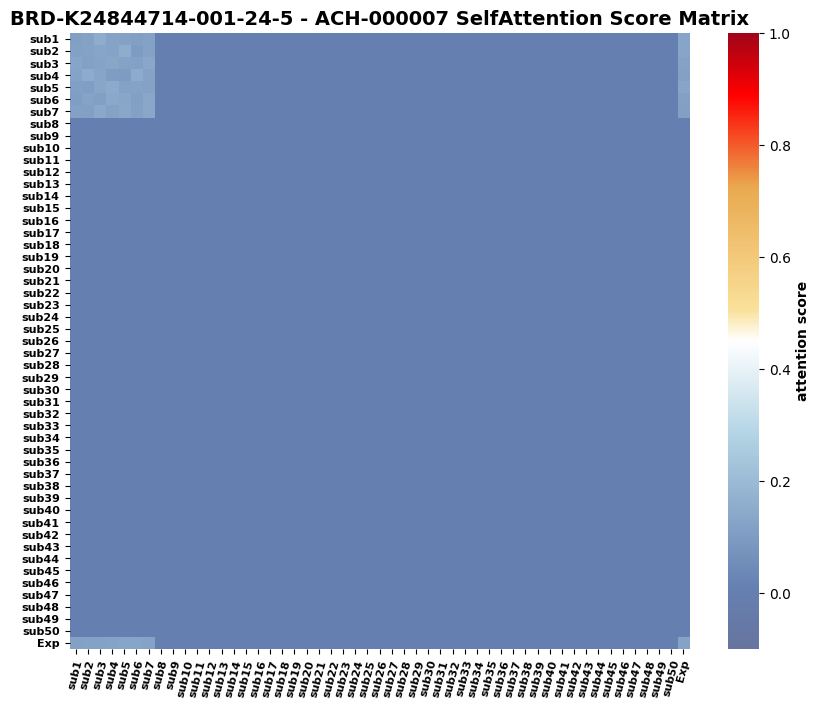

In [ ]:
heatmap(AttenScorMat_DrugCellSelf.cpu(), drug_ID, cell_ID, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugCellSelf")

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


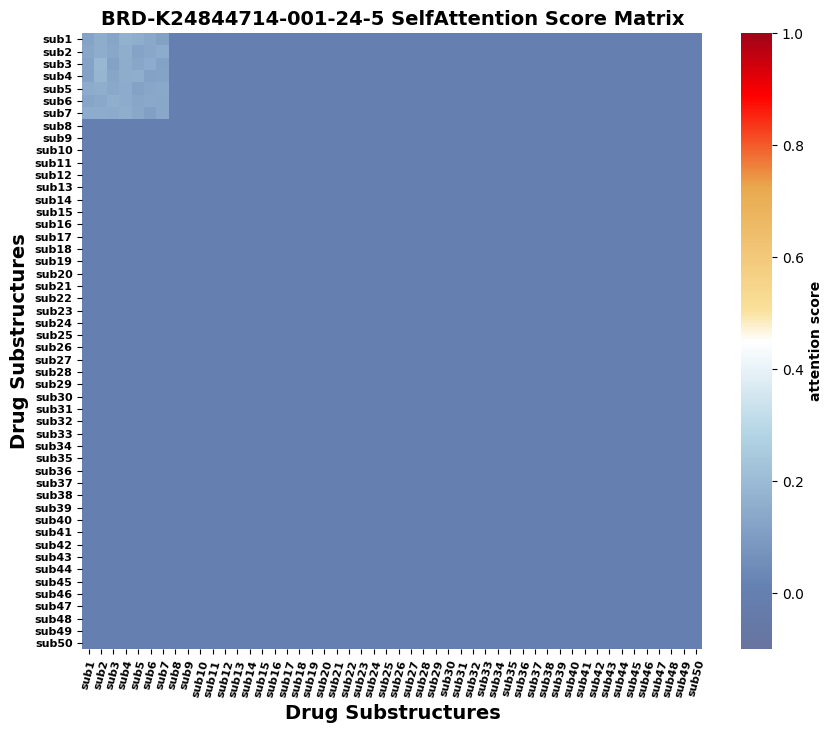

In [ ]:
heatmap(AttenScorMat_DrugSelf.cpu(), drug_ID, cell_ID, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugSelf" )

In [134]:
drug_encode.values[0][2]

['F', 'c1c[nH]', 'c', '(=O)', '[nH]', 'c1', '=O']

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


tensor([[[ 49, 616,  26,  63, 118,  70, 180,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0],
         [  1,   1,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0]]], device='cuda:0')
torch.Size([7, 7])


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


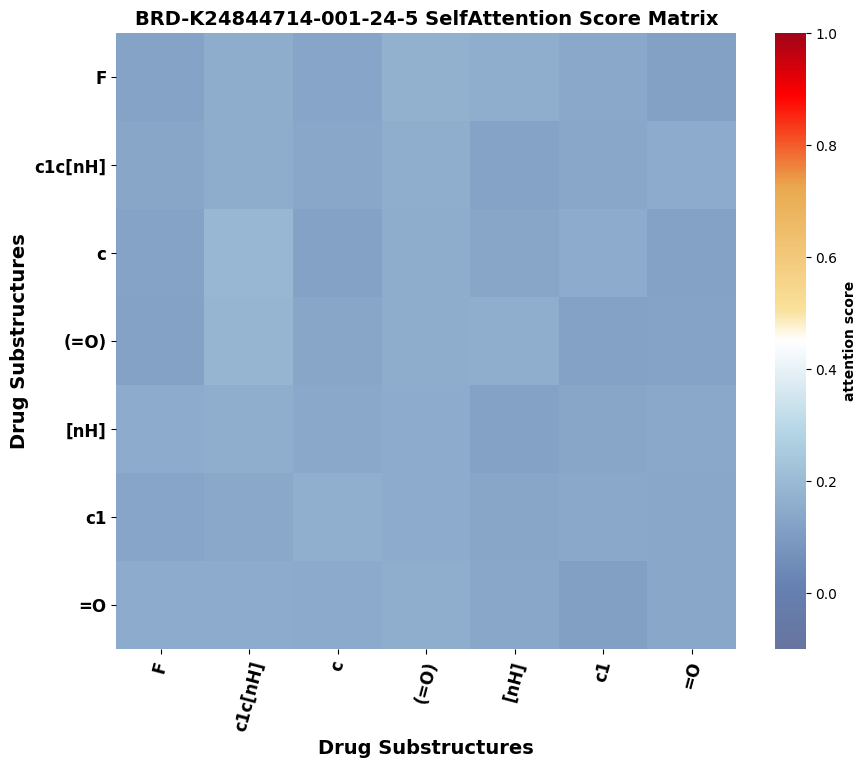

In [ ]:
print(drug_features_tensor) # Fc1c[nH]c(=O)[nH]c1=O 
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugSelf[~torch.all(AttenScorMat_DrugSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugSelf_dropnan.shape)
heatmap(AttenScorMat_DrugSelf_dropnan.cpu(), drug_ID, cell_ID, include_omics, fontsize_ticks=12, module="AttenScorMat_DrugSelf", sub= drug_encode.values[0][2])

In [141]:
top2 = torch.sort(AttenScorMat_DrugSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_i, max_j = divmod(top2[1][0].item(), AttenScorMat_DrugSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_i+1,",", "sub",max_j+1)
print(" max drug category index pair:",drug_features_tensor[0][0][max_i].item(),",",drug_features_tensor[0][0][max_j].item())
sec_max_i, sec_max_j = divmod(top2[1][1].item(), AttenScorMat_DrugSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_i+1,",", "sub",sec_max_j+1)
print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_i].item(),",",drug_features_tensor[0][0][sec_max_j].item())

top2 indices of flattened score matrix: [15, 22] 
 score values: [0.1894039809703827, 0.18077071011066437]
max score matrix index pair: sub 3 , sub 2
 max drug category index pair: 26 , 616
sec_max score matrix index pair: sub 4 , sub 2
 sec_max drug category index pair: 63 , 616


torch.Size([8, 8])


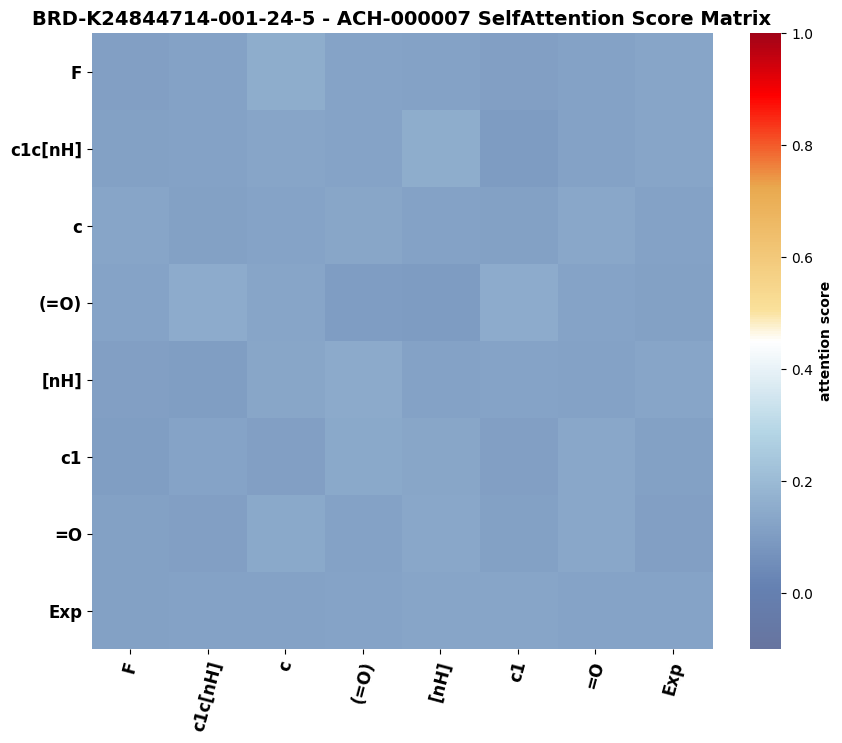

In [ ]:
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugCellSelf[~torch.all(AttenScorMat_DrugCellSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugCellSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugCellSelf_dropnan.shape)
heatmap(AttenScorMat_DrugCellSelf_dropnan.cpu(), drug_ID, cell_ID, include_omics, fontsize_ticks=12, module="AttenScorMat_DrugCellSelf", sub= drug_encode.values[0][2])

In [79]:
top2 = torch.sort(AttenScorMat_DrugCellSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_i, max_j = divmod(top2[1][0].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_i+1,",","sub", max_j+1)
print(" max drug category index pair:",drug_features_tensor[0][0][max_i].item(),",",drug_features_tensor[0][0][max_j].item())
sec_max_i, sec_max_j = divmod(top2[1][1].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_i+1,",", "sub",sec_max_j+1)
print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_i].item(),",",drug_features_tensor[0][0][sec_max_j].item())

top2 indices of flattened score matrix: [2, 12] 
 score values: [0.15619486570358276, 0.1537962704896927]
max score matrix index pair: sub 1 , sub 3
 max drug category index pair: 49 , 26
sec_max score matrix index pair: sub 2 , sub 5
 sec_max drug category index pair: 616 , 118


['F', 'c1c[nH]', 'c', '(=O)', '[nH]', 'c1', '=O']
